## Analysis and Testing of Neural Network Approach

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


2023-05-06 13:34:24.799916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing from `util.py`

In [228]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


def load_vehicle_data(vehicles_path='data'):
  csv_path = os.path.join(vehicles_path, "project_data.csv")
  return pd.read_csv(csv_path)


def remove_vehicle_data_noise(vehicles):
  # Removing outlier vehicle prices that are dramatically outside standard deviation
  vehicles.drop(vehicles[vehicles['selling_price'] >= 1650000].index, inplace = True)

  # Removing vehicles older than 2000 due to sparse inconsistent data
  vehicles.drop(vehicles[vehicles['year'] < int("2000")].index, inplace = True)

  # Removing sparse high mileage vehicles
  vehicles.drop(vehicles[vehicles['km_driven'] >= 240000].index, inplace = True)

  # Removing 'Test Drive Car' instances since it's NOT numerically related to other owner types
  # AND NOT BEING USED FOR ONE HOT ENCODING
  vehicles.drop(vehicles[vehicles['owner'] == 'Test Drive Car'].index, inplace = True)

  # Remove 'Electric' 'fuel' type since only 1 instance
  vehicles.drop(vehicles[vehicles['fuel'] == 'Electric'].index, inplace = True)
  

def convert_categories_to_integers(vehicles):
  # Creating numerical value for number of owner strings
  current_owner_strings = ['First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner']
  new_owner_strings = ['1', '2', '3', '4']
  vehicles['owner'] = vehicles['owner'].replace(current_owner_strings, new_owner_strings)
  vehicles['owner'] = vehicles['owner'].astype('int64') # Convert type to integers:

  # 0-indexing to convert category column's to be one hot encoded 
  current_owner_strings = ['Petrol', 'Diesel', 'CNG', 'LPG']
  new_strings = ['0', '1', '2', '3']
  vehicles['fuel'] = vehicles['fuel'].replace(current_owner_strings, new_strings)
  vehicles['fuel'] = vehicles['fuel'].astype('int64')

  current_owner_strings = ['Individual', 'Dealer', 'Trustmark Dealer']
  new_strings = ['0', '1', '2']
  vehicles['seller_type'] = vehicles['seller_type'].replace(current_owner_strings, new_strings)
  vehicles['seller_type'] = vehicles['seller_type'].astype('int64')

  current_owner_strings = ['Manual', 'Automatic']
  new_strings = ['0', '1']
  vehicles['transmission'] = vehicles['transmission'].replace(current_owner_strings, new_strings)
  vehicles['transmission'] = vehicles['transmission'].astype('int64')

  return vehicles

def normalize_numerical_data_attributes(data):
  numerical_data = data[['year', 'km_driven', 'owner']].copy()
  normaled = (numerical_data - numerical_data.mean()) / numerical_data.std()
  data.drop(['year', 'km_driven', 'owner'], axis=1, inplace = True)

  data['year'] = normaled['year']
  data['km_driven'] = normaled['km_driven']
  data['owner'] = normaled['owner']

  return data
  

# Helper function to create a new data set containing 'data_set'
# elements in 'column_name_str' of data set and remove
# that column from 'data_set' input
def extract_data_column_inplace(data_set, column_name_str):
  data_column = data_set[[column_name_str]].copy()
  data_set.drop([column_name_str], axis=1, inplace = True)

  return data_column


def create_neural_net_partitions_train(train_set):
  # Copying and deleting data for one hot coding portion of model
  train_set_one_hot_fuel = extract_data_column_inplace(train_set, 'fuel')
  train_set_one_hot_seller_type = extract_data_column_inplace(train_set, 'seller_type')
  train_set_one_hot_transmission = extract_data_column_inplace(train_set, 'transmission')

  # Extracting name attribute column
  train_set_names = extract_data_column_inplace(train_set, 'name')

  # Extracting selling price column
  train_set_labels = extract_data_column_inplace(train_set, 'selling_price')

  ''' Converting partittions to tensors '''
  train_set_tensor = tf.convert_to_tensor(train_set)
  train_set_one_hot_fuel_tensor = tf.convert_to_tensor(train_set_one_hot_fuel)
  train_set_one_hot_seller_type_tensor = tf.convert_to_tensor(train_set_one_hot_seller_type)
  train_set_one_hot_transmission_tensor = tf.convert_to_tensor(train_set_one_hot_transmission)
  train_set_names_tensor = tf.convert_to_tensor(train_set_names)
  train_set_labels_tensor = tf.convert_to_tensor(train_set_labels)

  return train_set_names, train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor, train_set_names_tensor, train_set_labels_tensor


def create_neural_net_partitions_test(test_set):
  test_set_one_hot_fuel = extract_data_column_inplace(test_set, 'fuel')
  test_set_one_hot_seller_type = extract_data_column_inplace(test_set, 'seller_type')
  test_set_one_hot_transmission = extract_data_column_inplace(test_set, 'transmission')

  test_set_names = extract_data_column_inplace(test_set, 'name')

  test_set_labels = extract_data_column_inplace(test_set, 'selling_price')

  test_set_tensor = tf.convert_to_tensor(test_set)
  test_set_one_hot_fuel_tensor = tf.convert_to_tensor(test_set_one_hot_fuel)
  test_set_one_hot_seller_type_tensor = tf.convert_to_tensor(test_set_one_hot_seller_type)
  test_set_one_hot_transmission_tensor = tf.convert_to_tensor(test_set_one_hot_transmission)
  test_set_names_tensor = tf.convert_to_tensor(test_set_names)
  test_set_labels_tensor = tf.convert_to_tensor(test_set_labels)

  return test_set_names, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor, test_set_names_tensor, test_set_labels_tensor


def load_preprocessed_data():
  vehicles = load_vehicle_data()

  remove_vehicle_data_noise(vehicles)

  converted_vehicles = convert_categories_to_integers(vehicles)

  converted_vehicles.reset_index(inplace=True)

  # Drop column old indexes created by calling 'reset_index'
  # converted_vehicles.drop(converted_vehicles['index'].index, inplace = True)
  converted_vehicles.drop(['index'], axis=1, inplace = True)

  normalize_numerical_data_attributes(converted_vehicles)

  # Split data
  train_set, test_set = train_test_split(vehicles, test_size=0.2, random_state=42)

  return train_set, test_set


## Get Data for Model

In [229]:
train_set, test_set = load_preprocessed_data()

# train_set_tensor and test_set_tensor both contain the numerical attributes
train_set_names, train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor, train_set_names_tensor, train_set_labels_tensor = create_neural_net_partitions_train(train_set)

test_set_names, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor, test_set_names_tensor, test_set_labels_tensor = create_neural_net_partitions_test(test_set)


# Model Architecture and Training

In [243]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Globals for word embedding's
EMBEDDING_DIMMENSIONS = 50
VOCARB_SIZE = 1550 # about 1427 unique names identified in dataset
MAX_LENGTH = 40 # approximate the largest vehicle name string


''' Handle data attributes ['year', 'km_driven', 'owner'] '''
numerical_inputs = tf.keras.layers.Input(shape=[3], dtype=tf.float32, name='year_kmDriven_owner_attributes')
# batch_numeric = tf.keras.layers.BatchNormalization()(numerical_inputs)


''' Handle 'name' attribute '''
name_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='name_attribute')

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCARB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LENGTH)
vectorize_layer.adapt(train_set_names) # Create vector table for data
vectorize_layer.adapt(test_set_names)

vectorized_input = vectorize_layer(name_inputs)
name_embed = tf.keras.layers.Embedding(input_length=MAX_LENGTH, input_dim=VOCARB_SIZE, output_dim=EMBEDDING_DIMMENSIONS, name='embedding')(vectorized_input)
flattened_embedding = tf.keras.layers.Flatten()(name_embed)


''' Handle each one hot encoded input'''
# Handle and encode 'fuel' data
one_hot_input_fuel = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='fuel_attribute')
one_hot_encoder_fuel = tf.keras.layers.CategoryEncoding(num_tokens=4, output_mode='one_hot')(one_hot_input_fuel)

# Handle and encode 'seller_type' data
one_hot_input_seller_type = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='seller_type_attribute')
one_hot_encoder_seller_type = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode='one_hot')(one_hot_input_seller_type)

# Handle and encode 'seller_type' data
one_hot_input_transmission = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='transmission_attribute')
one_hot_encoder_transmission  = tf.keras.layers.CategoryEncoding(num_tokens=2, output_mode='one_hot')(one_hot_input_transmission)


''' Concatenate all data inputs together '''
all_inputs = tf.keras.layers.Concatenate()([flattened_embedding, numerical_inputs, one_hot_encoder_fuel, one_hot_encoder_seller_type, one_hot_encoder_transmission])


''' MODEL BODY  '''
first_dense = tf.keras.layers.Dense(512, kernel_initializer='he_normal', activation='relu')(all_inputs)
second_dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')(first_dense)
third_dense = tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu')(second_dense)
fourth_dense = tf.keras.layers.Dense(64, kernel_initializer='he_normal', activation='relu')(third_dense)
fifth_dense = tf.keras.layers.Dense(32, kernel_initializer='he_normal', activation='relu')(fourth_dense)
sixth_dense = tf.keras.layers.Dense(8, kernel_initializer='he_normal', activation='relu')(fifth_dense)
seventh_dense = tf.keras.layers.Dense(4, kernel_initializer='he_normal', activation='relu')(sixth_dense)
output = tf.keras.layers.Dense(1, activation='linear')(seventh_dense)
model = tf.keras.Model(inputs=[name_inputs, numerical_inputs , one_hot_input_fuel, one_hot_input_seller_type, one_hot_input_transmission], outputs=[output])
ad_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model.compile(optimizer=ad_optimizer, loss="mean_squared_error")

In [244]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# history = model.fit([train_set_names_tensor, train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor], train_set_labels_tensor, callbacks=[early_stopping_cb], epochs=140, batch_size=32)

# Training with validation split
history = model.fit([train_set_names_tensor , train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor], train_set_labels_tensor, validation_split=0.2, callbacks=[early_stopping_cb], epochs=140, batch_size=32)

Epoch 1/140
83/83 [==============================] - 2s 13ms/step - loss: 222345658368.0000 - val_loss: 84010958848.0000
Epoch 2/140
83/83 [==============================] - 1s 9ms/step - loss: 83197165568.0000 - val_loss: 67723837440.0000
Epoch 3/140
83/83 [==============================] - 1s 9ms/step - loss: 62637555712.0000 - val_loss: 40817819648.0000
Epoch 4/140
83/83 [==============================] - 1s 9ms/step - loss: 34925346816.0000 - val_loss: 26772983808.0000
Epoch 5/140
83/83 [==============================] - 1s 14ms/step - loss: 24013049856.0000 - val_loss: 22719715328.0000
Epoch 6/140
83/83 [==============================] - 1s 12ms/step - loss: 19368183808.0000 - val_loss: 20837349376.0000
Epoch 7/140
83/83 [==============================] - 1s 8ms/step - loss: 16591827968.0000 - val_loss: 17199452160.0000
Epoch 8/140
83/83 [==============================] - 1s 10ms/step - loss: 14420354048.0000 - val_loss: 15753678848.0000
Epoch 9/140
83/83 [========================

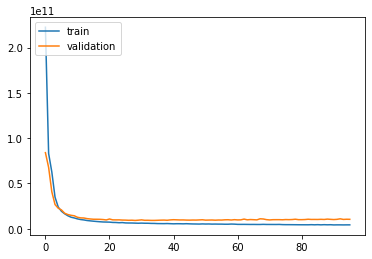

In [245]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [246]:
index = 0
percentage_totals = 0
for item in model.predict([test_set_names_tensor, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor]):
  # print(f'(predicted, actual) = ({item[0]},{test_set_labels_tensor[index].numpy()})')
  # print(f"predicted - actual = {item[0] - test_set_labels_tensor[index].numpy()}")

  percentage_error = ((test_set_labels_tensor[index].numpy() - item[0]) / test_set_labels_tensor[index].numpy() ) * 100
  # print("percentage_error = ", percentage_error)

  percentage_totals += abs(percentage_error)
  
  index += 1



print("AVERAGE PERCENTAGE ERROR = ", percentage_totals / len(test_set_labels_tensor))

26/26 [==============================] - 1s 3ms/step
AVERAGE PERCENTAGE ERROR =  [18.63902718]


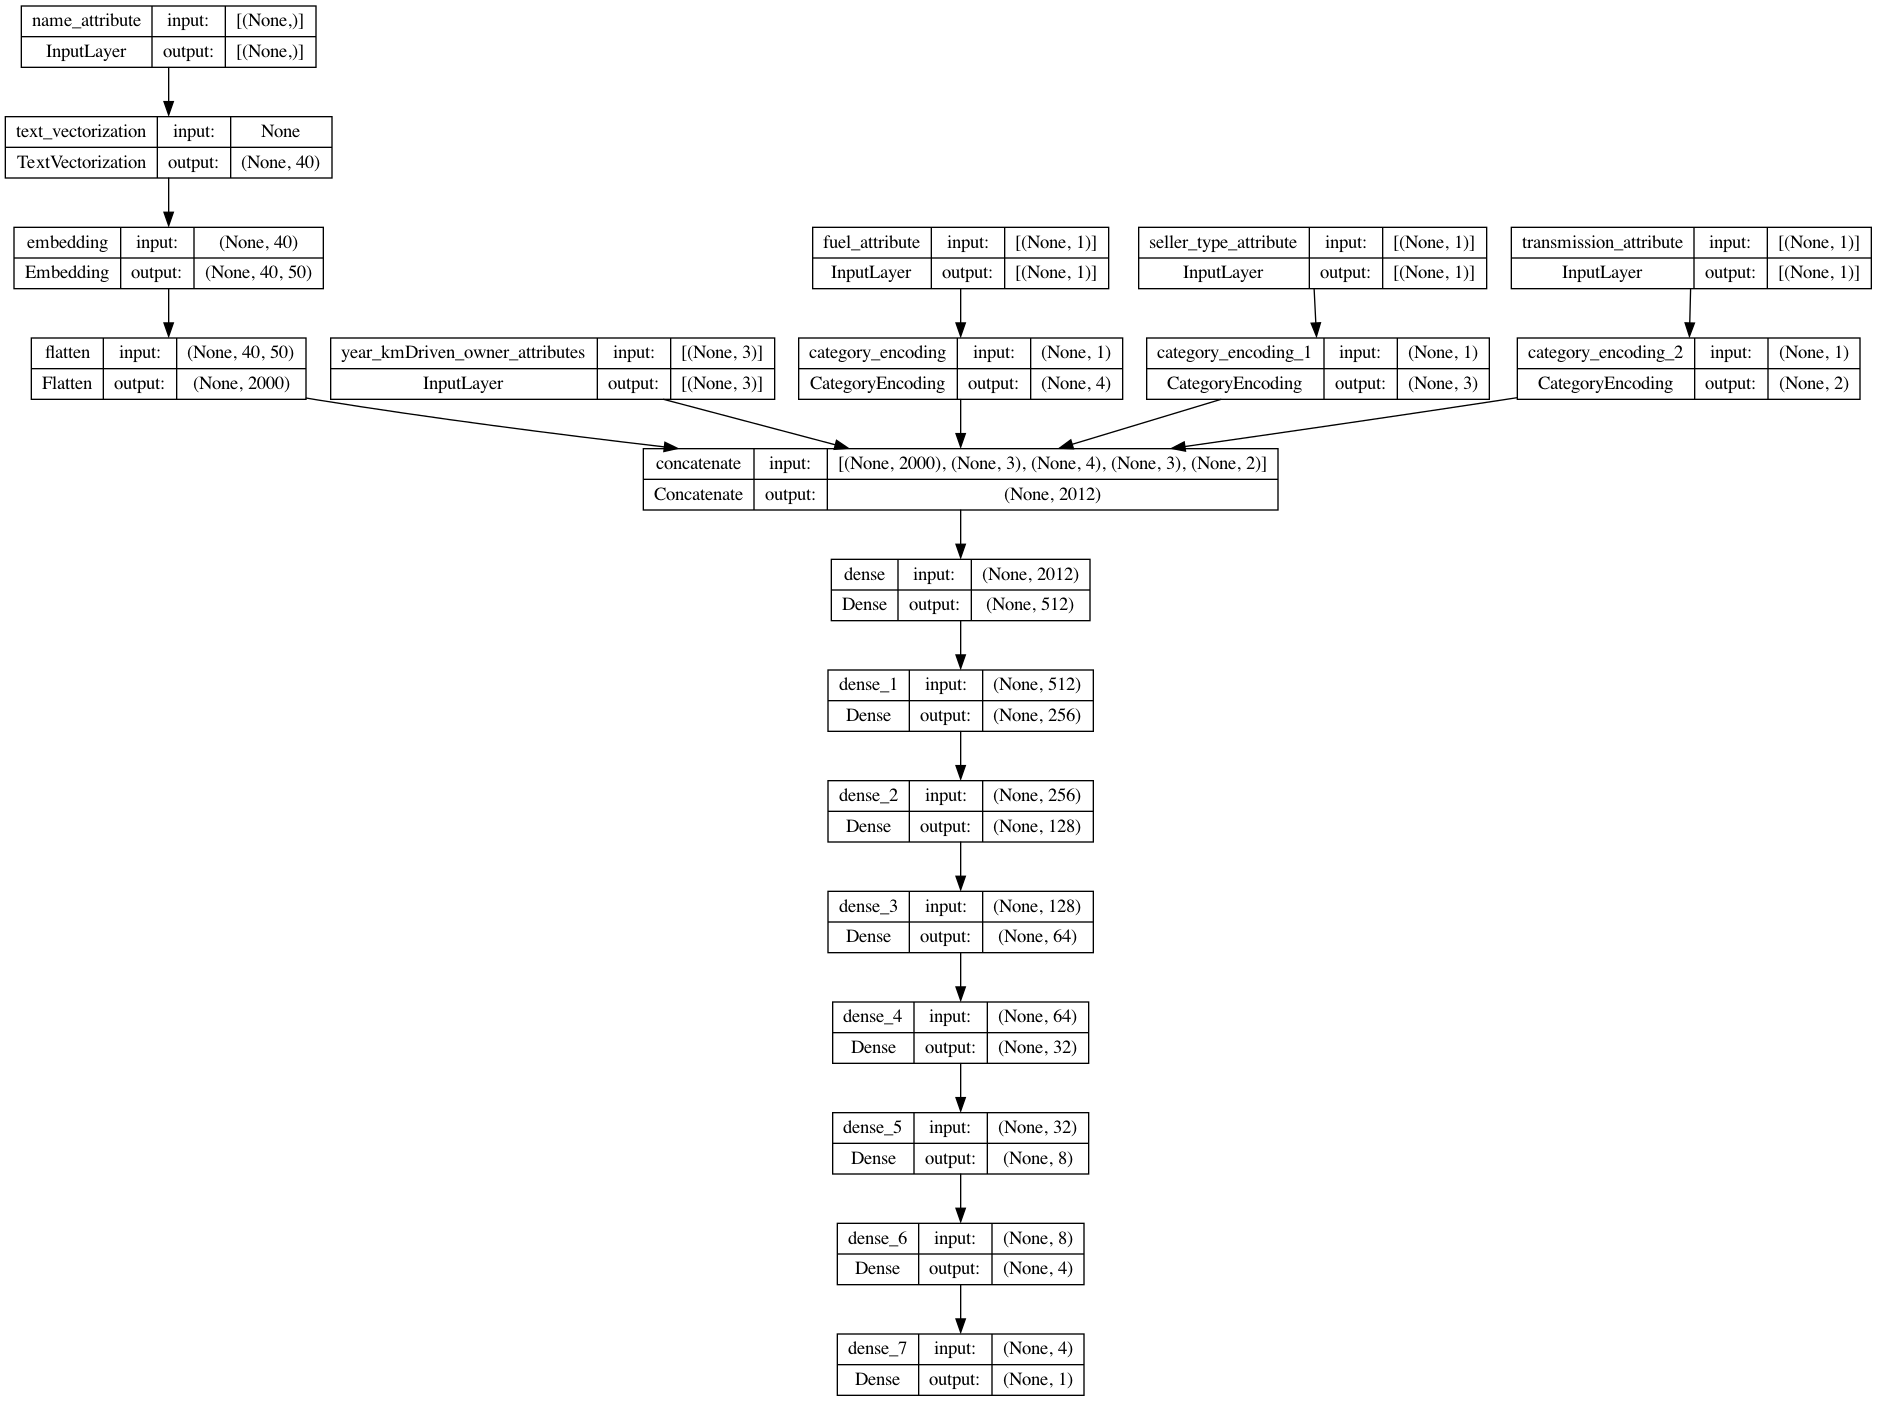

In [247]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Save Model and Training Data

In [248]:
tf.keras.Model.save(model, 'model_18_63_percentage_error')

INFO:tensorflow:Assets written to: model_18_63_percentage_error/assets


INFO:tensorflow:Assets written to: model_18_63_percentage_error/assets


In [249]:
import pickle

with open('model_18_63_percentage_error_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)